**Problem 3.1**

Attributions: Shashank and Elena did part **a**. Elena and Michelle did **b**. Shashank did **c**. Michelle did **d** and **e**.

**a)** First we import the usual modules.


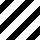
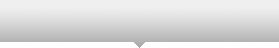
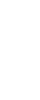
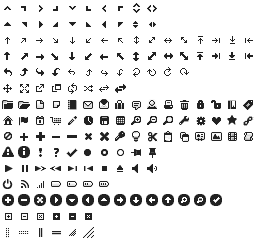
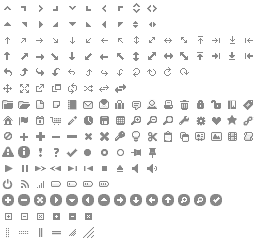
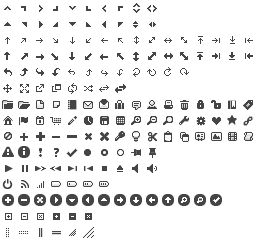
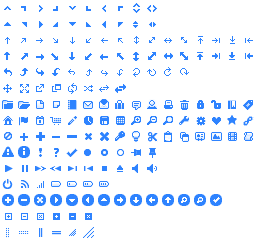
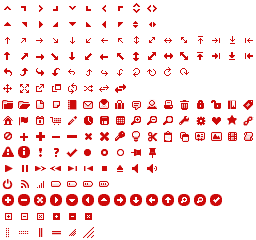
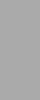
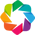
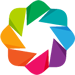
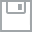
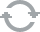
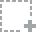
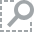
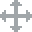
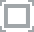
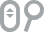

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.special
import beeswarm as bs
import seaborn as sns
import numdifftools as ndt

# Bokeh stuff
import bokeh.io
import bokeh.mpl
import bokeh.plotting

%matplotlib inline

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

Next, we read in the two datasets as Pandas `DataFrames`. 

In [2]:
# Read in the dataset
AerobicIntensity = pd.read_csv("data/20151001_aerobic_mean_intensities.csv",comment="#")
AnaerobicIntensity = pd.read_csv("data/20151001_anaerobic_mean_intensities.csv", comment="#")

AerobicIntensity.head()

0 plasmids/cell  10^1 plasmids/cell  10^2 plasmids/cell  \
0       107.737249          105.097792          106.845238   
1       109.843794          102.075567          106.576923   
2       107.533228          102.937931          106.522358   
3       107.875289          103.765487          106.480663   
4       109.094017          105.121118          104.895810   

   10^3 plasmids/cell  10^4 plasmids/cell  10^5 plasmids/cell  
0          104.485356          169.438242          111.046339  
1          104.136622          117.837283          215.607085  
2          105.623410          150.432234          115.541296  
3          104.078212          115.597059          141.717617  
4          102.788732          132.905286          107.345992

In [3]:
AnaerobicIntensity.head()

0 plasmids/cell  10^1 plasmids/cell  10^2 plasmids/cell  \
0       105.212500          104.238739          103.066667   
1       104.511254          103.918619          103.363229   
2       106.051625          103.953608          102.555035   
3       103.634241          103.371528          102.973529   
4       104.882897          104.415459          103.840746   

   10^3 plasmids/cell  10^4 plasmids/cell  10^5 plasmids/cell  
0          102.989024          112.567732          108.008909  
1          103.045845          103.782544          104.361919  
2          103.908479          104.415214          104.712895  
3          103.535368          101.867410          177.966820  
4          103.622363          159.855365          104.092664

The data are not tidy. To make tidying easier, we rename the columns to plain numerical values before melting the `DataFrames`.

In [4]:
# Change column names to make melting easier
AerobicIntensity.columns = ["0", "1e1", "1e2", "1e3", "1e4", "1e5"]
AnaerobicIntensity.columns = ["0", "1e1", "1e2", "1e3", "1e4", "1e5"]

# Melt untidy data to create tidy dataframes
CleanAerobic = pd.melt(AerobicIntensity, var_name="PlasmidsPerCell", value_name= "MeanPixel").dropna()
CleanAnaerobic = pd.melt(AnaerobicIntensity, var_name="PlasmidsPerCell", value_name= "MeanPixel").dropna()

CleanAerobic.head()

PlasmidsPerCell   MeanPixel
0               0  107.737249
1               0  109.843794
2               0  107.533228
3               0  107.875289
4               0  109.094017

In [5]:
CleanAnaerobic.head()

PlasmidsPerCell   MeanPixel
0               0  105.212500
1               0  104.511254
2               0  106.051625
3               0  103.634241
4               0  104.882897

We are asked to compute the number of of transformed cells, which requires us to decide on a criterion for what constitutes a transformed cell. Our first thought was to plot a histogram of the the mean pixel values to see if there were two clear peaks in frequency, in which case we would have set our cutoff for transformed vs. non-transformed somewhere in between the two peaks. We chose a large number of bins in order to increase the chance of seeing distinct peaks.

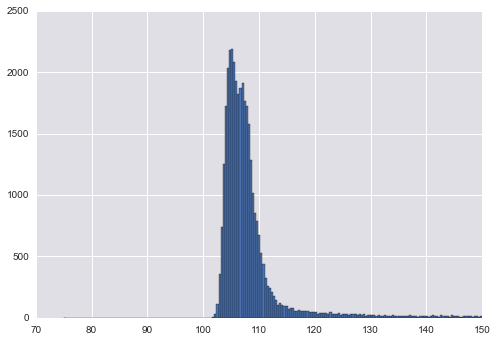

In [6]:
# Plot a histogram of the mean pixel values for the aerobic dataset 
_ = plt.hist(CleanAerobic["MeanPixel"],bins=200, range=[75,150]) 

It doesn't look like there are two distinct peaks, probably because overall there are so many more untransformed cells than transformed cells. So we came up with an alternative: find the maximum mean pixel value under the zero plasmids/cell condition, since we know for sure that none of those cells could have been transformed. We will round up to the nearest integer from that maximum and call that our cutoff for transformed vs. non-transformed cells. We note that this metric is not immune to false positives: it is possible that the cells in the zero plasmids/cell condition in this dataset do not encompass the full range of possible mean pixel values for non-transformed cells. However, although we could reduce the number of false positives by setting our cutoff at some arbitrary higher value, we prefer a greater risk of false positives as compared to false negatives. 

In [7]:
np.max(CleanAerobic[CleanAerobic["PlasmidsPerCell"]=="0"].MeanPixel)

111.99305555555556

In [8]:
np.max(CleanAnaerobic[CleanAnaerobic["PlasmidsPerCell"]=="0"].MeanPixel)

109.59493670886076

We got two different maximum values for the two datasets. For the sake of consistency, we will take the higher of the two values and use it as our cutoff for both. So we define transformed cells as all cells with MeanPixel $\geq$ 112.0.

Now we need to compute the number of transformed cells in each dataset.

In [9]:
# Create new DataFrames containing only transformed cells, i.e. cells above our mean pixel value cutoff
TransformedCellsAerobic = CleanAerobic[CleanAerobic["MeanPixel"] > 112.0]
TransformedCellsAnaerobic = CleanAnaerobic[CleanAnaerobic["MeanPixel"] > 112.0]

# We want to count the number of transformed cells, and we'll also go ahead and count the number of total cells 
# since we will need this value later to determine the probability of transformation
NtAerobic = TransformedCellsAerobic['MeanPixel'].count()
NAerobic = CleanAerobic['MeanPixel'].count()

NtAnaerobic = TransformedCellsAnaerobic['MeanPixel'].count()
NAnaerobic = CleanAnaerobic['MeanPixel'].count()

print('Number of transformed cells in Aerobic dataset: ' + str(NtAerobic))
print('Number of total cells in Aerobic dataset: ' + str(NAerobic))
print('Number of transformed cells in Anaerobic dataset: ' + str(NtAnaerobic))
print('Number of total cells in Anaerobic: ' + str(NAnaerobic))

Number of transformed cells in Aerobic dataset: 7314
Number of total cells in Aerobic dataset: 38963
Number of transformed cells in Anaerobic dataset: 1925
Number of total cells in Anaerobic: 27876


**b)** Now that we have defined our parameters, we can plot our posterior. For our posterior distribution, we chose the binomial distribution as our likelihood since 1) we are dealing with Boolean data (either cell is transformed or it is not) and 2) we are interested in the probability of getting a certain number of successes (transformations) out of a given number of trials. Likelihood:
\begin{align}
P(n_t \mid n,p,I) = \frac{n!}{n_t!(n - n_t)!}p^{n_t}(1 - p)^{n - n_t}
\end{align}

For the prior, we assumed we do not know anything about the probability $p$ of transformation of a given cell, so we assume a uniform prior for $p$ between 0 and 1. Prior:
\begin{align}
P(p \mid n,I) = \left\{
\begin{array}{cl}
1 & 0 \leq p \leq 1\\
0 & \mathrm{otherwise}
\end{array}
\right.
\end{align}

For our normalization constant $P(n_t \mid n, I)$, we recalled that there are $n + 1$ possible numbers of transformants from $n$ cells (because there could be zero transformants). Since we assumed no prior knowledge, all possible numbers of transformants should be equally likely, so $P(n_t \mid n, I) = \frac{1}{n \, + \, 1}$.

With the likelihood, prior, and normalization constant as defined above, our posterior distribution is:

\begin{align}
P(p \mid n_t,n,I) = \left\{
\begin{array}{cl}
\frac{(n \, + \, 1)!}{n_t!(n \, - \, n_t)!}p^{n_t}(1 - p)^{n - n_t} & 0 \leq p \leq 1\\
0 & \mathrm{otherwise}
\end{array}
\right.
\end{align}

We needed to define a Python function for our posterior. We could use the `scipy.misc.comb` function to combute the cominbation, but we recieved the following error:
`OverflowError: int too large to conver to float`. We switched to defining the log of our posterior because we recieve the error: `OverflowError: int too larg to conver to float`. Using the log of our posterior will help us get around this. We used the scipy.special.gammaln function to deal with the factorials in our posterior:
\begin{align}
\Gamma(n) = (n - 1)!
\end{align}

In [10]:
# Let's compute the log of the posterior
# We can use a scipy.special function to deal with the factorials

def log_posterior(nt, n, p):
    '''
    Log of posterior for Boolean data.
    '''
    return scipy.special.gammaln(n + 2) - scipy.special.gammaln(nt +1) - scipy.special.gammaln(n - nt +1) \
           + nt * np.log(p) + (n - nt) * np.log(1 - p)   

Now we can plot the posteriors of our aerobic and anaerobic data sets. Since we defined a the log of our posterior we can plot our posteriors by taking the exponential of the `log_posterior`. 

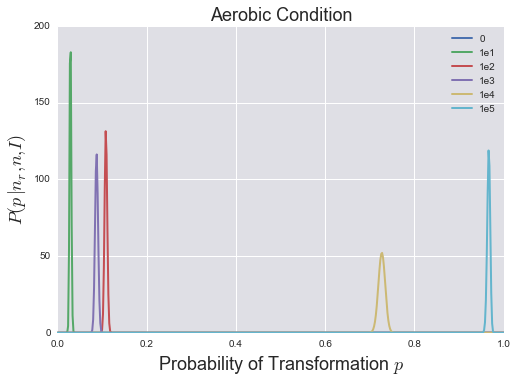

In [11]:
# We want to group our data by plasmid concentration for both transformed cells and total cells
TransformedAerobic = TransformedCellsAerobic.groupby('PlasmidsPerCell')
TransformedAnaerobic = TransformedCellsAnaerobic.groupby('PlasmidsPerCell')
CleanAerobic_group = CleanAerobic.groupby('PlasmidsPerCell')
CleanAnaerobic_group = CleanAnaerobic.groupby('PlasmidsPerCell')

# We can count our nt and n (transformed cells and total cells)
NtAerobic = TransformedAerobic['PlasmidsPerCell'].count()
NAerobic = CleanAerobic_group['PlasmidsPerCell'].count()

NtAnaerobic = TransformedAnaerobic['MeanPixel'].count()
NAnaerobic = CleanAnaerobic_group['MeanPixel'].count()

# let's create an set of evenly spaced numbers for p
# Our maximum probability is 1 and minium probability is 0, so we set our interval
p = np.linspace (0, 1, 500)

# Now we can plot our posteriors for the aerobic data sets
# We were working with the log of our posteriors because the int value of our posterior was too big for python to handle
# To plot our posteriors, we can simply take the exponential 
# When we do .groupby there are no transformed cells under the group 0 plasmids per cell so the indices of
# NtAerobic and NAerobic are off by one
plt.plot(p, np.exp(log_posterior(0, NAerobic[0], p)), '-')
plt.plot(p, np.exp(log_posterior(NtAerobic[0], NAerobic[1], p)), '-')
plt.plot(p, np.exp(log_posterior(NtAerobic[1], NAerobic[2], p)), '-')
plt.plot(p, np.exp(log_posterior(NtAerobic[2], NAerobic[3], p)), '-')
plt.plot(p, np.exp(log_posterior(NtAerobic[3], NAerobic[4], p)), '-')
plt.plot(p, np.exp(log_posterior(NtAerobic[4], NAerobic[5], p)), '-')

plt.legend(('0', '1e1', '1e2', '1e3', '1e4', '1e5'), loc = 'upper right')
plt.xlabel('Probability of Transformation $p$')
plt.ylabel(r'$P(p\mid n_r, n, I)$')
plt.title('Aerobic Condition')


Now we can plot our posterior distribution for our anaerobic data sets.

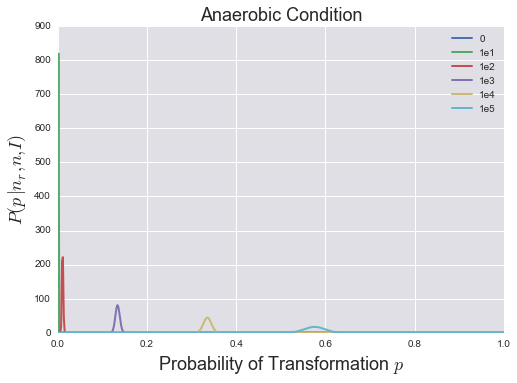

In [12]:
# let's create an set of evenly spaced numbers for p
# Our maximum probability is 1 and minium probability is 0, so we set our interval
p = np.linspace (0, 1, 500)

# Now we can plot our posteriors for both the aerobic and anaerobic data sets
# We were working with the log of our posteriors because the int value of our posterior was too big for python to handle
# To plot our posteriors, we can simply take the exponential 
# When we do .groupby there are no transformed cells under the group 0 plasmids per cell so the indices of
# NtAnaerobic and NAnaerobic are off by one
plt.plot(p, np.exp(log_posterior(0, NAnaerobic[0], p)), '-')
plt.plot(p, np.exp(log_posterior(NtAnaerobic[0], NAnaerobic[1], p)), '-')
plt.plot(p, np.exp(log_posterior(NtAnaerobic[1], NAnaerobic[2], p)), '-')
plt.plot(p, np.exp(log_posterior(NtAnaerobic[2], NAnaerobic[3], p)), '-')
plt.plot(p, np.exp(log_posterior(NtAnaerobic[3], NAnaerobic[4], p)), '-')
plt.plot(p, np.exp(log_posterior(NtAnaerobic[4], NAnaerobic[5], p)), '-')

plt.legend(('0', '1e1', '1e2', '1e3', '1e4', '1e5'), loc = 'upper right')
plt.xlabel('Probability of Transformation $p$')
plt.ylabel(r'$P(p\mid n_r, n, I)$')
plt.title('Anaerobic Condition')

**c)** First of all, we will simplify the expression for $\sigma^2$. The original expression according to the question was:

\begin{align}
\sigma^2 = \frac{ (p^*)^2\,(1-p^*)^2}{n\,(p^*)^2 + n_t(1-2p^*)} \\[1em]
=\frac{ (p^*)^2\,(1-p^*)^2}{n\,(\,(p^*)^2 + p^*\,(1-2p^*)\,)} \\[1em]
=\frac{ (p^*)^2\,(1-p^*)^2}{n\,(\,(p^*)^2 + p^*-2(p^*)^2)\,)} \\[1em]
=\frac{ (p^*)^2\,(1-p^*)^2}{n\,(\,p^*-(p^*)^2)\,)} \\[1em]
=\frac{(p^*)^2\,(1-p^*)^2}{n\,p^*\,(1-p^*)}
\end{align}


After simplification, we are left with:

\begin{align}
\sigma^2 = \frac{p^*\,(1-p^*)}{n}
\end{align}

The posterior distribution is given by:
\begin{align}
P(p \mid n_t,n,I) = \frac{(n+1)!}{(n-n_t)!\,n_t!}\,{p}^{n_t}\,{1-p}^{n-n_t} \\[1em]
\end{align}

Taking $\log$ on both sides,
\begin{align}
\ln\, P(\,p \mid n_t,n,I)= \ln\,(\frac{(n+1)!}{(n-n_t)!\,n_t!}) + n_t\ln\,p + (n-n_t)\,ln\,(1-p)
\end{align}

To make the Gaussian approximation, we expand the logarithm of the posterior in a Taylor series to second order. First let's find the first derivative of the log posterior function.

\begin{align}
\frac{d}{dp}\ln\, P(\,p \mid n_t,n,I) = 0 + \frac{n_t}{p} + \frac{n-n_t}{(1-p)}(-1) \\[1em]
= \frac{n_t}{p}-\frac{n-n_t}{1-p} \\[1em]
\end{align}

\begin{align}
\text{When}  \,p = p^* = \frac{n_t}{n}, \\[1em]
\frac{d}{dp}\ln\, P(\,p \mid n_t,n,I) = \frac{n_t}{p^*} - \frac{n\,(1-p^*)}{1-p^*} \\[1em]
= n - n = 0 \\[1em]
\end{align}

Hence, the derivative of the log posterior function at $p = p^*$ is 0.


Next, let's calculate the second derivative.
\begin{align}
\frac{d^2}{dp^2}\ln\, P(\,p \mid n_t,n,I) = 0 + \frac{n_t}{p^2}(-1) - \frac{n-n_t}{(1-p)^2}(-1)(-1) \\[1em]
=-\frac{n_t}{p^2} - \frac{n-n_t}{(1-p)^2} \\[1em]
\end{align}

\begin{align}
\text{When}  \,p = p^*, \\[1em]
\frac{d^2}{dp^2}\ln\, P(\,p \mid n_t,n,I) = -\frac{n\,p^*}{(p^*)^2} - \frac{n(1-p^*)}{(1-p^*)^2} \\[1em]
= -n \,(\frac{1}{p^*} + \frac{1}{1-p^*}) \\[1em]
= -n \,(\frac{1-p^*+p^*}{p^*(1-p^*)}) \\[1em]
= \frac{-n}{p^*(1-p^*)} \\[1em]
= -\frac{1}{\sigma^2}
\end{align}

Thus our Taylor series expansion gives:

\begin{align}
\ln\, P(\,p \mid n_t,n,I) \approx \text{constant} - \frac{n(p - p^*)^2}{p^*(1-p^*)}
\end{align}

Exponentiating this expression, we get that:

\begin{align}
P(p \mid n_t,n,I) \approx \frac{1}{\sqrt{\frac{2\pi p^*\,(1-p^*)}{n}}}\,
\exp\left[-\frac{(\theta - \bar{l})^2}{\frac{2p^*\,(1-p^*)}{n}}\right]
\end{align}

This completes our derivation of the Gaussian approximation of the posterior. We see one potential issue with this approximation: the binomial distribution is discrete whereas the Gaussian distribution is continuous. Our data are discrete (i.e., only an integer number of cells can be transformed). Thus, the Gaussian approximation says there is some finite probability of existing at values at which our data actually cannot exist.  

**d)** First we can define our $p^*$ and $\sigma$. We were able to simplify the $\sigma^2$ given in the problem set to be:
\begin{align}
\sigma^2 = \frac{ p^* \, (1 - p^*)}{n}
\end{align}

In [13]:
# We can define
def pStar(nt, n):
    '''
    Define p*
    '''
    return nt/n

def Sigma(nt, n):
    '''
    Define sigma
    '''
    return np.sqrt(pStar(nt, n) * (1 - pStar(nt, n)) / n)

We can plot $p^*$ versus Plasmid Concentration for our aerobic data set with error bars using the `plt.errorbar` function, then use Bokeh to make the plot zoomable because the error bars are tiny and hard to see.

In [14]:
x = [0, 10**1, 10**2, 10**3,10**4,10**5]

y = [pStar(0, NAerobic[0]), pStar(NtAerobic[0], NtAerobic[1]), pStar(NtAerobic[1], NAerobic[2]), \
     pStar(NtAerobic[2], NAerobic[3]), pStar(NtAerobic[3], NAerobic[4]), pStar(NtAerobic[4], NAerobic[5])]
yerr = [Sigma(0, NAerobic[0]), Sigma(NtAerobic[0], NAerobic[1]), Sigma(NtAerobic[1], NAerobic[2]), \
        Sigma(NtAerobic[2], NAerobic[3]), Sigma(NtAerobic[3], NAerobic[4]), Sigma(NtAerobic[4], NAerobic[5])]

plt.errorbar(x, y, yerr = yerr, fmt = '.', ecolor = 'green', capthick = 1)

plt.xlim(0, 10**5)
plt.ylim(-0.1, 1)
bokeh.plotting.show(bokeh.mpl.to_bokeh())
# Zoom in with Bokeh to see our error bars

C:\Users\Elena\Anaconda3\lib\site-packages\bokeh\compat\bokeh_renderer.py:218: UserWarning: Unable to handle marker: _; defaulting to Circle
  warnings.warn("Unable to handle marker: %s; defaulting to Circle" % style['marker'])
C:\Users\Elena\Anaconda3\lib\site-packages\bokeh\compat\bokeh_renderer.py:218: UserWarning: Unable to handle marker: .; defaulting to Circle
  warnings.warn("Unable to handle marker: %s; defaulting to Circle" % style['marker'])


It looks like it would be a good idea to plot our x-axis on a log scale. We can do that using the `matplotlib` function `plt.xscale('log')`. Unfortunately `bokeh` does not recognize this function, but let's take a look at how this would look.

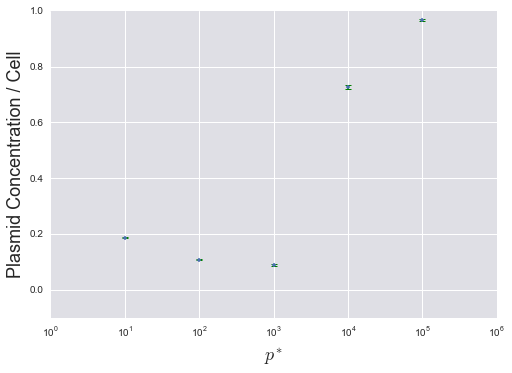

In [15]:
x = [0, 10**1, 10**2, 10**3,10**4,10**5]

y = [pStar(0, NAerobic[0]), pStar(NtAerobic[0], NtAerobic[1]), pStar(NtAerobic[1], NAerobic[2]), \
     pStar(NtAerobic[2], NAerobic[3]), pStar(NtAerobic[3], NAerobic[4]), pStar(NtAerobic[4], NAerobic[5])]
yerr = [Sigma(0, NAerobic[0]), Sigma(NtAerobic[0], NAerobic[1]), Sigma(NtAerobic[1], NAerobic[2]), \
        Sigma(NtAerobic[2], NAerobic[3]), Sigma(NtAerobic[3], NAerobic[4]), Sigma(NtAerobic[4], NAerobic[5])]

plt.errorbar(x, y, yerr = yerr, fmt = '.', ecolor = 'green', capthick = 1)

plt.xlim(1, 10**6)
plt.ylim(-0.1, 1)
plt.xscale('log')
plt.xlabel('$p^*$')
plt.ylabel('Plasmid Concentration / Cell')

We think this is a better way to present our data, so we can try to do this in `bokeh`. If we want to plot with a log scale for our x-axis, we can do this with setting `x_axis_type = 'log'` when plotting out data points in a bokeh figure. First we plot the data point using the `p.circle` function. Then to create the error bars we add and subtract our y-error as a line to the points using the `p.multi_line` `bokeh` function to create a line that has the length of an error bar.

In [16]:
from bokeh.plotting import figure, output_file, show

# We chose 1e-5 as our zero value because a log scale plot does not have a zero
xs = [1e-5, 10**1, 10**2, 10**3,10**4,10**5]
ys = [pStar(0, NtAerobic[0]), pStar(NtAerobic[0], NtAerobic[1]), pStar(NtAerobic[1], NAerobic[2]), \
        pStar(NtAerobic[2], NAerobic[3]), pStar(NtAerobic[3], NAerobic[4]), pStar(NtAerobic[4], NAerobic[5])]
yerrs = [Sigma(0, NAerobic[0]),Sigma(NtAerobic[0], NAerobic[1]), Sigma(NtAerobic[1], NAerobic[2]), \
        Sigma(NtAerobic[2], NAerobic[3]), Sigma(NtAerobic[3], NAerobic[4]), Sigma(NtAerobic[4], NAerobic[5])]


# plot the points
p = figure(title='Aerobic', width=500, height=400, x_axis_type='log')

p.xaxis.axis_label = 'Plasmid Concentration/ Cell'
p.yaxis.axis_label = 'p*'

p.circle(xs, ys, color='blue', size=5, line_alpha=0)


# create the coordinates for the errorbars
err_xs = []
err_ys = []

# We add our yerr value to the top and bottom of our y value to create an error bar
for x, y, yerr in zip(xs, ys, yerrs):
    err_xs.append((x, x))
    err_ys.append((y - yerr, y + yerr))
    


# plot them
p.multi_line(err_xs, err_ys, color = 'red', line_width = 5, alpha = 0.5)
show(p)

# If the x-axis title is off-center, just try panning in Bokeh

Our error bars are so small because our p* values are so small. That's why we use bokeh so you can zoom into the data set and see the error bar. 

We can do this for our anaerobic data as well.

In [17]:
from bokeh.plotting import figure, output_file, show

xa = [1e-5, 10**1, 10**2, 10**3, 10**4, 10**5]
ya = [pStar(0, NAnaerobic[0]), pStar(NtAnaerobic[0], NtAnaerobic[1]), pStar(NtAnaerobic[1], NAnaerobic[2]),\
      pStar(NtAnaerobic[2], NAnaerobic[3]), pStar(NtAnaerobic[3], NAnaerobic[4]),\
      pStar(NtAnaerobic[4], NAnaerobic[5])]
yerra = [Sigma(0, NAnaerobic[0]), Sigma(NtAnaerobic[0], NAnaerobic[1]), Sigma(NtAnaerobic[1], NAnaerobic[2]),\
         Sigma(NtAnaerobic[2], NAnaerobic[3]), Sigma(NtAnaerobic[3], NAnaerobic[4]), \
         Sigma(NtAnaerobic[4], NAnaerobic[5])]

# plot the points
p = figure(title='Anaerobic', width=500, height=400, x_axis_type='log')

p.xaxis.axis_label = 'Plasmid Concentration/ Cell'
p.yaxis.axis_label = 'p*'

p.circle(xa, ya, color='blue', size=5, line_alpha=0)


# put the error bars in the right location
err_xa = []
err_ya = []

for x, y, yerr in zip(xa, ya, yerra):
    err_xa.append((x, x))
    err_ya.append((y - yerr, y + yerr))

p.multi_line(err_xa, err_ya, color = 'red', line_width = 5, alpha = 0.5)
show(p)

**e)** We want to find a value for $r_0$. Let's start with finding the rate bacteria can take up a plasmid under aerobic conditions. $r_0$ is constant for all plasmid concentrations. The probability that a cell takes up one plasmid and is thus transformed is:
\begin{align}
p = 1 - e^{-r_0c\tau}
\end{align}
Where c is the plasmid concentration and $\tau$ is the time a cell has to take up a plasmid, in this experiment 1 hour. 
From part d we found the probability of transformation for each plasmid concentration, $p_i^*$. We can fit $r_0$ based on the $p_i^*$ and $\sigma_i*$ we calculated for each plasmid concentration in part d. Also we can set $\tau$ to 1 because we wash the DNA away after 1 hour in our experiments. So what we have is:
\begin{align}
1 - e^{-r_0c} = p^*
\end{align}
We can simplify that to
\begin{align}
e^{-r_0c} = 1 - p^*
\end{align}
Now we can apply this to each plasmid concentration 
\begin{align}
\Pi e^{-r_0c_i} = \Pi (1 - (p_i^* \pm \sigma_i))
\end{align}

\begin{align}
e^{-r_0\Sigma c_i} = \Pi (1 - (p_i^* \pm \sigma_i))
\end{align}

\begin{align}
-r_0\Sigma c_i = log{\Pi (1 - (p_i^* \pm \sigma_i))}
\end{align}

\begin{align}
r_0 = \frac{-log{\Pi (1 - (p_i^* \pm \sigma_i))}}{\Sigma c_i}
\end{align}

Now we can start defining our function. We start by making a `numpy array` of our number of transformed cells and total number of cells for each plasmid concentrations, pstar, and sigma from part d. 

In [18]:
Nt = (0, NtAerobic[0], NtAerobic[1], NtAerobic[2], NtAerobic[3], NtAerobic[4])
N = (NAerobic[0], NAerobic[1], NAerobic[2], NAerobic[3], NAerobic[4], NAerobic[5])
Nt = np.array(Nt)
N = np.array(N)

pstar = pStar(Nt, N)
sigma = Sigma(Nt, N)

Now we can define our $\Pi (1 - p_i^*)$ and our $r_0$

In [19]:
# We define a list of the concentrations
concentrations = [0, 10**2, 10**3, 10**4, 10**5]

# We define our p* products
def pstarProd(nt, n):
    '''
    Returns a value for r_0 without errors before log
    '''
    return (1 - pstar[0]) * (1 - pstar[1]) * (1 - pstar[2]) * (1 - pstar[3]) * (1 - pstar[4]) * (1 - pstar[5])

# We can now calculat our r_0 value
def r0(nt, n):
    '''
    Returns our r0 value
    '''
    return - np.log(pstarProd(nt, n)) / np.sum(concentrations)

To calculate our error we define a list of functions just to keep things clear. We are calculating our error such that
\begin{align}
\mathrm{total \, error} = p_1^* * \sigma_2 + p_2^* * \sigma_1
\end{align}
In this case `sigma[0] = 0` so we have:
\begin{align}
(1 - (p_1^* \pm 0))*(1 - (p_2^* \pm \sigma_2))
\end{align}
And we can calculate `error0` as such:
\begin{align}
p_1^* * p_2^* + \sigma_2
\end{align}

In [20]:
def error0(nt, n):
    '''
    Return error value 0
    '''
    return pstar[1] * pstar[2] + sigma[2]
def error1(nt, n):
    '''
    Returns the error value part 1
    '''
    return pstar[1] * pstar[0] + sigma[1]

def error2(nt, n):
    '''
    Returns the error value part 1
    '''
    return pstar[2] * error1(nt, n) + pstar[0] * pstar[1] * sigma[2]
def error3(nt, n):
    '''
    Returns the error value part 1
    '''
    return pstar[3] * error2(nt, n) + pstar[0] * pstar[1] * pstar[2] * sigma[3]
def error4(nt, n):
    '''
    Returns the error value part 1
    '''
    return pstar[4] * error3(nt, n) + pstar[0] * pstar[1] * pstar[2] * pstar[3] * sigma[4]
def error5(nt, n):
    '''
    Returns the error value part 1
    '''
    return pstar[5] * error4(nt, n) + pstar[0] * pstar[1] * pstar[2] * pstar[3] * pstar[4] * sigma[5]

# error5 is our final error 

We want to print out our $r_0$ with our errors. 

In [21]:
r = r0(Nt, N)
error = error5(Nt, N)

print("""Aerobic Model
r0 = {0:f} ± {1:f} µm
""".format(r, error))

Aerobic Model
r0 = 0.000044 ± 0.000013 µm



Now we want to plot our regression line against the plot we got in part d. We can begin by defining our theoretical model. 

In [22]:
# we create a list of the plasmid concetrations
c = [0, 10**1, 10**2, 10**3, 10**4, 10**5]

# we make this list into a numpy array
C = np.array(c)

def theory(c):
    '''
    Theorhetical probability
    '''
    return 1 - np.exp(-r * c * 1)


Now we are ready to plot our regression line against out $p^*$ vs Plasmid concentration plot from part d. 

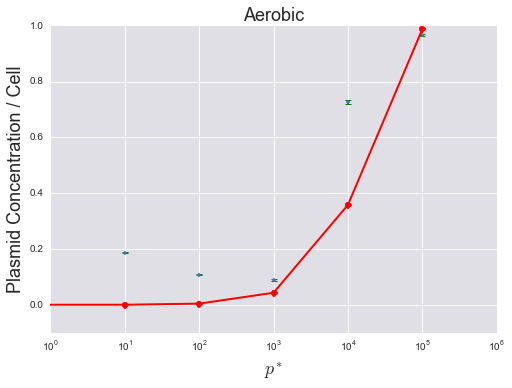

In [23]:
# We define x for both our theorhetical and our p* vs. Plasmid concentration plot
x = [0, 10**1, 10**2, 10**3,10**4,10**5]

# We define the y values for our p* vs. plasmid concentration
y = [pStar(0, NAerobic[0]), pStar(NtAerobic[0], NtAerobic[1]), pStar(NtAerobic[1], NAerobic[2]), \
     pStar(NtAerobic[2], NAerobic[3]), pStar(NtAerobic[3], NAerobic[4]), pStar(NtAerobic[4], NAerobic[5])]

# We define the y values for our theorhetical model
yt = list(theory(C))

# We now define our error for the p* vs plasmid concentration
yerr = [Sigma(0, NAerobic[0]), Sigma(NtAerobic[0], NAerobic[1]), Sigma(NtAerobic[1], NAerobic[2]), \
        Sigma(NtAerobic[2], NAerobic[3]), Sigma(NtAerobic[3], NAerobic[4]), Sigma(NtAerobic[4], NAerobic[5])]

# plot p* versus plasmid concentration
plt.errorbar(x, y, yerr = yerr, fmt = '.', ecolor = 'green', capthick = 1)

# plot our theorhetical model
plt.plot(x, yt, marker = 'o', color = 'red')

plt.xlim(1, 10**6)
plt.ylim(-0.1, 1)
plt.xscale('log')
plt.xlabel('$p^*$')
plt.ylabel('Plasmid Concentration / Cell')
plt.title('Aerobic')

Now we can do the same thing for our anaerobic data set. 

Anaerobic Model
$r_0$ = 0.000013 ± 0.000000 µm



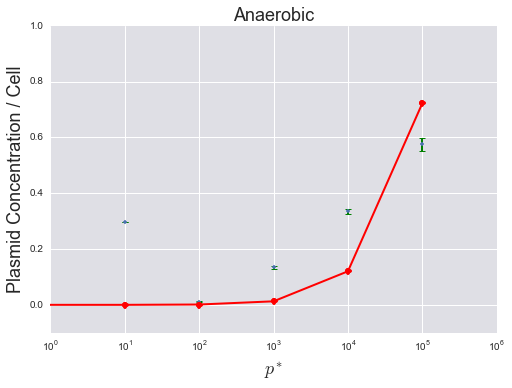

In [24]:
Nt = (0, NtAnaerobic[0], NtAnaerobic[1], NtAnaerobic[2], NtAnaerobic[3], NtAnaerobic[4])
N = (NAnaerobic[0], NAnaerobic[1], NAnaerobic[2], NAnaerobic[3], NAnaerobic[4], NAnaerobic[5])
Nt = np.array(Nt)
N = np.array(N)

pstar = pStar(Nt, N)
sigma = Sigma(Nt, N)

# We define a list of the concentrations
concentrations = [0, 10**2, 10**3, 10**4, 10**5]

# We define our p* products
def pstarProd(nt, n):
    '''
    Returns a value for r_0 without errors before log
    '''
    return (1 - pstar[0]) * (1 - pstar[1]) * (1 - pstar[2]) * (1 - pstar[3]) * (1 - pstar[4]) * (1 - pstar[5])

# We can now calculat our r_0 value
def r0(nt, n):
    '''
    Returns our r0 value
    '''
    return - np.log(pstarProd(nt, n)) / np.sum(concentrations)

def error0(nt, n):
    '''
    Return error value 0
    '''
    return pstar[1] * pstar[2] + sigma[2]
def error1(nt, n):
    '''
    Returns the error value part 1
    '''
    return pstar[1] * pstar[0] + sigma[1]

def error2(nt, n):
    '''
    Returns the error value part 1
    '''
    return pstar[2] * error1(nt, n) + pstar[0] * pstar[1] * sigma[2]
def error3(nt, n):
    '''
    Returns the error value part 1
    '''
    return pstar[3] * error2(nt, n) + pstar[0] * pstar[1] * pstar[2] * sigma[3]
def error4(nt, n):
    '''
    Returns the error value part 1
    '''
    return pstar[4] * error3(nt, n) + pstar[0] * pstar[1] * pstar[2] * pstar[3] * sigma[4]
def error5(nt, n):
    '''
    Returns the error value part 1
    '''
    return pstar[5] * error4(nt, n) + pstar[0] * pstar[1] * pstar[2] * pstar[3] * pstar[4] * sigma[5]

# error5 is our final error 

r = r0(Nt, N)
error = error5(Nt, N)

print("""Anaerobic Model
$r_0$ = {0:f} ± {1:f} µm
""".format(r, error))

# we create a list of the plasmid concetrations
c = [0, 10**1, 10**2, 10**3, 10**4, 10**5]

# we make this list into a numpy array
C = np.array(c)

def theory(c):
    '''
    Theorhetical probability
    '''
    return 1 - np.exp(-r * c * 1)

# We define x for both our theorhetical and our p* vs. Plasmid concentration plot
x = [0, 10**1, 10**2, 10**3,10**4,10**5]

# We define the y values for our p* vs. plasmid concentration
y = [pStar(0, NAnaerobic[0]), pStar(NtAnaerobic[0], NtAnaerobic[1]), pStar(NtAnaerobic[1], NAnaerobic[2]), \
     pStar(NtAnaerobic[2], NAnaerobic[3]), pStar(NtAnaerobic[3], NAnaerobic[4]), pStar(NtAnaerobic[4], NAnaerobic[5])]

# We define the y values for our theorhetical model
yt = list(theory(C))

# We now define our error for the p* vs plasmid concentration
yerr = [Sigma(0, NAnaerobic[0]), Sigma(NtAnaerobic[0], NAnaerobic[1]), Sigma(NtAnaerobic[1], NAnaerobic[2]), \
        Sigma(NtAnaerobic[2], NAnaerobic[3]), Sigma(NtAnaerobic[3], NAnaerobic[4]), Sigma(NtAnaerobic[4], NAnaerobic[5])]

# plot p* versus plasmid concentration
plt.errorbar(x, y, yerr = yerr, fmt = '.', ecolor = 'green', capthick = 1)

# plot our theorhetical model
plt.plot(x, yt, marker = 'o', color = 'red')

plt.xlim(1, 10**6)
plt.ylim(-0.1, 1)
plt.xscale('log')
plt.xlabel('$p^*$')
plt.ylabel('Plasmid Concentration / Cell')
plt.title('Anaerobic')

It looks like assuming a Poisson process doesn't actually give great regression curves in these two cases. However, the curve looks like it might fit a little better for the data not including the 0 or 10 plasmids/cell condition. Perhaps this is an artifact of the way we defined transformed cells. 